In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from pathlib import Path  
from utils import filter_by_column_value, plot_range_pie

In [3]:
#enrich the dataset with as much features as possible before training (non-disruptions)
dataset_pre = pd.read_csv('preprocessed_data/merged_journeys.csv')

In [4]:
dataset_pre.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,Part number,Cancelled,Departure platform changed,Arrival platform changed
0,15086865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2025-01-01T02:02:00+01:00,2025-01-01T02:12:00+01:00,0.0,1.0,1,0,False,False
1,15086865,Intercity,DT,GV,Delft,Den Haag HS,2025-01-01T02:12:00+01:00,2025-01-01T02:19:00+01:00,1.0,1.0,2,0,False,False
2,15086865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2025-01-01T02:22:00+01:00,2025-01-01T02:31:00+01:00,0.0,0.0,3,0,False,False
3,15086865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2025-01-01T02:33:00+01:00,2025-01-01T02:56:00+01:00,0.0,0.0,4,0,False,True
4,15086865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2025-01-01T02:59:00+01:00,2025-01-01T03:07:00+01:00,0.0,0.0,5,0,True,False


In [5]:

def add_new_weekday_feature(dataset):
    new_weekday_feature = []
    for idx, date_row in dataset.iterrows():
        departure_time = datetime.fromisoformat(date_row["Departure time"])
        arrival_time = datetime.fromisoformat(date_row["Arrival time"])
        day_number_dep = departure_time.weekday()
        day_number_arr = arrival_time.weekday()
        if (day_number_dep == 6 and day_number_arr == 0):
            new_weekday_feature.append(False)
        elif (day_number_dep >= 5 and day_number_arr >= 5):
            new_weekday_feature.append(True)
        elif (day_number_dep < 5 and day_number_arr < 5):
            new_weekday_feature.append(False)
        else:
            new_weekday_feature.append(True)
    dataset['Is_weekend'] = new_weekday_feature
    return dataset

def check_if_date_is_peak_hour(hour, minute):
    if ((hour == 6 and minute >= 30) or (6 < hour < 9) or (hour == 9 and minute == 0)):
        return True
    elif (hour == 16 or hour == 17):
        return True
    elif (hour == 18 and minute <= 30):
        return True
    return False

def add_new_rush_hour_feature(dataset):
    rush_hour_flags = []

    for _, row in dataset.iterrows():
        # Parse datetime
        dep_time = row["Departure time"]
        arr_time = row["Arrival time"]

        if isinstance(dep_time, str):
            dep_time = datetime.fromisoformat(dep_time)
        if isinstance(arr_time, str):
            arr_time = datetime.fromisoformat(arr_time)

        # Only check for rush hour if it's a weekday (0 = Mon, 6 = Sun)
        if dep_time.weekday() < 5 or arr_time.weekday() < 5:
            dep_flag = check_if_date_is_peak_hour(dep_time.hour, dep_time.minute)
            arr_flag = check_if_date_is_peak_hour(arr_time.hour, arr_time.minute)
            rush_hour_flags.append(dep_flag or arr_flag)
        else:
            rush_hour_flags.append(False)

    dataset["Is rush hour"] = rush_hour_flags
    return dataset

def extract_holidays(dataset):
    holiday_yes_or_no = []
    list_with_holidays = [
            '2023-01-01',   # New Year's Day
            '2023-04-07',   # Good Friday
            '2023-04-09',   # Easter Sunday
            '2023-04-10',   # Easter Monday
            '2023-04-27',   # King's Day
            '2023-05-05',   # Liberation Day
            '2023-05-18',   # Ascension Day
            '2023-05-28',   # Whit Sunday
            '2023-05-29',   # Whit Monday
            '2023-12-25',   # Christmas Day
            '2023-12-26',   # Second Christmas Day
            '2024-01-01',   # New Year's Day
            '2024-03-29',   # Good Friday
            '2024-03-31',   # Easter Sunday
            '2024-04-01',   # Easter Monday
            '2024-04-27',   # King's Day
            '2024-05-05',   # Liberation Day
            '2024-05-09',   # Ascension Day
            '2024-05-19',   # Whit Sunday
            '2024-05-20',   # Whit Monday
            '2024-12-25',   # Christmas Day
            '2024-12-26',   # Second Christmas Day
            '2025-01-01',   # New Year's Day
            '2025-04-18',   # Good Friday
            '2025-04-20',   # Easter Sunday
            '2025-04-21',   # Easter Monday
            '2025-04-26',   # King's Day
            '2025-05-05',   # Liberation Day
            '2025-05-29',   # Ascension Day
            '2025-06-08',   # Whit Sunday
            '2025-06-09',   # Whit Monday
            '2025-12-25',   # Christmas Day
            '2025-12-26',   # Second Christmas Day
        ]
    converted_holidays = {date.fromisoformat(d) for d in list_with_holidays}

    for _, date_row in dataset.iterrows():
        # Convert the 'Date' column to strings in the same format
        departure_time = datetime.fromisoformat(date_row["Departure time"])
        arrival_time = datetime.fromisoformat(date_row["Arrival time"])
        # Create the 'Is_holiday' column based on the 'Date' column
        holiday_yes_or_no.append(
            departure_time.date() in converted_holidays or arrival_time.date() in converted_holidays
        )   
    dataset['Is_holiday'] = holiday_yes_or_no
    # Create the 'Is_holiday' column based on the 'Date' column
    return dataset
    
def data_preprocessing_main_dataset(dataset):
    dataset = add_new_weekday_feature(dataset)
    dataset = extract_holidays(dataset)
    dataset = add_new_rush_hour_feature(dataset)
    return dataset


In [6]:
dataset_pre = data_preprocessing_main_dataset(dataset_pre)

In [7]:
def plot_range_pie(df, column, ranges):
    #create a pie chart to visualize different delay ranges in dataset
    #to get an insight about the delays, to later evenly split it for classification.
    total = len(df)

    # counts per slice
    counts = [df[column].between(lo, hi, inclusive="both").sum()
              for lo, hi in ranges]

    # overall % per slice (share of ALL rows)
    percentages = [cnt / total * 100 for cnt in counts]

    # formatted strings: "<range> - <percentage>, <occurrences>"
    summary_strings = [
        f"{lo}–{hi} - {pct:.1f}%, {cnt}"
        for (lo, hi), pct, cnt in zip(ranges, percentages, counts)
    ]

    # ------ PLOT -------
    fig, ax = plt.subplots()
    wedges, _, _ = ax.pie(
        counts,
        startangle=90,
        autopct=lambda pct: f"{pct:.1f}%",  # keeps wedge labels
        textprops={'weight': 'bold'}
    )
    ax.legend(
        wedges,
        [f"{lo}–{hi}" for lo, hi in ranges],
        title="Ranges",
        loc="center left",
        bbox_to_anchor=(1, 0.5)
    )
    ax.set_title(f"Distribution of '{column}' (N={total})")
    ax.axis("equal")
    plt.tight_layout()
    plt.show()

    # ------ PRINT LIST -------
    for s in summary_strings:
        print(s)

    # also return it for programmatic use
    return summary_strings

In [8]:
dataset_pre.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,Part number,Cancelled,Departure platform changed,Arrival platform changed,Is_weekend,Is_holiday,Is rush hour
0,15086865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2025-01-01T02:02:00+01:00,2025-01-01T02:12:00+01:00,0.0,1.0,1,0,False,False,False,True,False
1,15086865,Intercity,DT,GV,Delft,Den Haag HS,2025-01-01T02:12:00+01:00,2025-01-01T02:19:00+01:00,1.0,1.0,2,0,False,False,False,True,False
2,15086865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2025-01-01T02:22:00+01:00,2025-01-01T02:31:00+01:00,0.0,0.0,3,0,False,False,False,True,False
3,15086865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2025-01-01T02:33:00+01:00,2025-01-01T02:56:00+01:00,0.0,0.0,4,0,False,True,False,True,False
4,15086865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2025-01-01T02:59:00+01:00,2025-01-01T03:07:00+01:00,0.0,0.0,5,0,True,False,False,True,False


In [9]:
ranges = [(0, 0), (1, 1)]

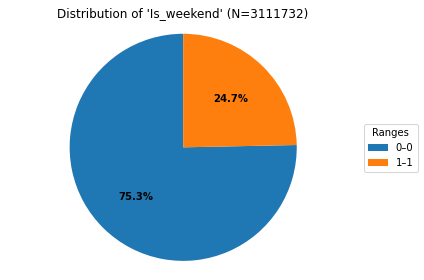

0–0 - 75.3%, 2343930
1–1 - 24.7%, 767802


['0–0 - 75.3%, 2343930', '1–1 - 24.7%, 767802']

In [10]:
plot_range_pie(dataset_pre, "Is_weekend", ranges)

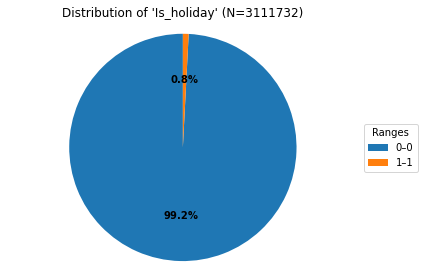

0–0 - 99.2%, 3086356
1–1 - 0.8%, 25376


['0–0 - 99.2%, 3086356', '1–1 - 0.8%, 25376']

In [11]:
plot_range_pie(dataset_pre, "Is_holiday", ranges)

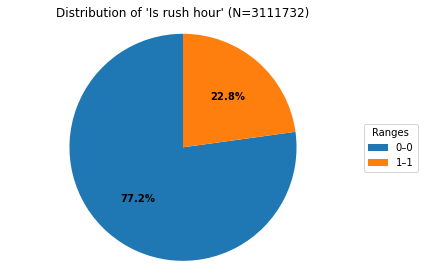

0–0 - 77.2%, 2401612
1–1 - 22.8%, 710120


['0–0 - 77.2%, 2401612', '1–1 - 22.8%, 710120']

In [12]:
plot_range_pie(dataset_pre, "Is rush hour", ranges)

In [13]:
plot_delays_by_rush_hour = filter_by_column_value(dataset_pre, "Is rush hour", 1)

In [14]:
test_ranges_1 = [(0,0), (1, 2), (3, 5), (6, 10), (11, 20), (21, 40), (41, 180), (180, 1001)]

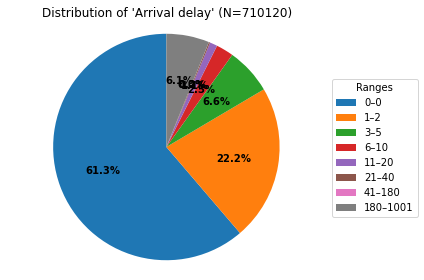

0–0 - 61.3%, 435054
1–2 - 22.2%, 157884
3–5 - 6.6%, 47023
6–10 - 2.5%, 17703
11–20 - 1.1%, 7617
21–40 - 0.2%, 1314
41–180 - 0.0%, 66
180–1001 - 6.1%, 43459


['0–0 - 61.3%, 435054',
 '1–2 - 22.2%, 157884',
 '3–5 - 6.6%, 47023',
 '6–10 - 2.5%, 17703',
 '11–20 - 1.1%, 7617',
 '21–40 - 0.2%, 1314',
 '41–180 - 0.0%, 66',
 '180–1001 - 6.1%, 43459']

In [16]:
plot_range_pie(plot_delays_by_rush_hour, "Arrival delay", test_ranges_1)

In [25]:
plot_delays_by_day_of_week = filter_by_column_value(dataset_pre, "Is_holiday", 1)

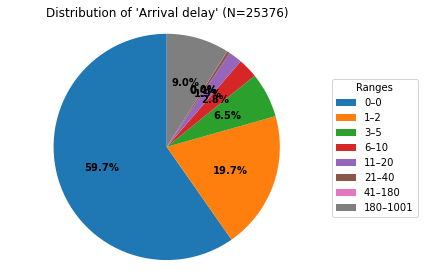

0–0 - 59.7%, 15151
1–2 - 19.7%, 4994
3–5 - 6.5%, 1637
6–10 - 2.8%, 715
11–20 - 1.9%, 494
21–40 - 0.4%, 102
41–180 - 0.0%, 5
180–1001 - 9.0%, 2278


['0–0 - 59.7%, 15151',
 '1–2 - 19.7%, 4994',
 '3–5 - 6.5%, 1637',
 '6–10 - 2.8%, 715',
 '11–20 - 1.9%, 494',
 '21–40 - 0.4%, 102',
 '41–180 - 0.0%, 5',
 '180–1001 - 9.0%, 2278']

In [27]:
plot_range_pie(plot_delays_by_day_of_week, "Arrival delay", test_ranges_1)

## Conclusion
All features are important to have in the dataset - as seen by delays, every feature directly impacts the delay time

#### Weekends
A bit less delays over weekends

#### Holidays
Much more cancellations on holidays, a bit more significant delays

#### Rush hour
More delays during rush hours, as predicted

### Features that influence departure delay most:
1. Departure platform changed
2. Arrival platform changed
3. Is holiday
4. Is rush hour
5. Train type
6. Is weekend

In [38]:
departure_platform_changed = filter_by_column_value(dataset_pre, "Arrival platform changed", 1)

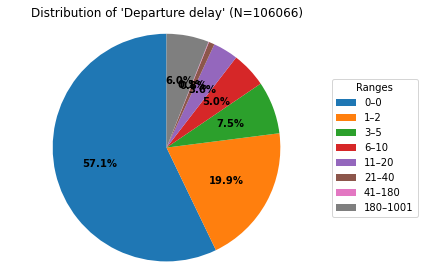

0–0 - 57.1%, 60613
1–2 - 19.9%, 21073
3–5 - 7.5%, 7938
6–10 - 5.0%, 5334
11–20 - 3.6%, 3784
21–40 - 0.8%, 865
41–180 - 0.1%, 85
180–1001 - 6.0%, 6373


['0–0 - 57.1%, 60613',
 '1–2 - 19.9%, 21073',
 '3–5 - 7.5%, 7938',
 '6–10 - 5.0%, 5334',
 '11–20 - 3.6%, 3784',
 '21–40 - 0.8%, 865',
 '41–180 - 0.1%, 85',
 '180–1001 - 6.0%, 6373']

In [41]:
plot_range_pie(departure_platform_changed, "Departure delay", test_ranges_1)

In [42]:
dataset_pre.to_csv('preprocessed_data/preprocessed_time_features_added.csv', index=False)